In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score,roc_auc_score, roc_curve
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
import re
import nltk
import time
from sklearn.utils import shuffle
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# mount gdrive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Step1: Loading Data

In the EDA section, we find out that data before 2011 are mostly unlabeled, which means they have little spoiler records. Here we filter out all the records before 2011, and randomly sample 20k records from the filtered data set to form a new data set we deal with.

In [ ]:
# change root to the necessary path
root = "/gdrive/MyDrive/ads_proj5/ads-spring-2022-prj5-group-4/"
outputs_dir = root + "output/"

In [ ]:
data = pd.read_csv(outputs_dir+'goodreads_reviews_spoiler.csv')
books_info = pd.read_csv(root+"data/books.csv",on_bad_lines='skip')

In [ ]:
books_info = books_info[["bookID","title"]]
books_info = books_info.rename(columns={"bookID":"book_id"})

In [ ]:
data = data.merge(books_info,on="book_id")
data = data.drop('Unnamed: 0', axis=1)

In [ ]:
# has_spoiler(0: this sentence has no spoiler, 1: this sentence has spoiler)
data = data.drop("has_spoiler",axis=1)
df = data.rename(columns={"class": "has_spoiler"}, errors="raise")
df.head(3)

,review_id,has_spoiler,review,book_id,rating,timestamp,user_id,title
0,000d87e353329a4f1f938980cef15d5d,0,Pure Magic....loved it!!!,16793,5,2009-08-01,c3247a4c3cfc1fb4403c758b0ce5b209,Stardust
1,0f6d9eee40140fa244bd4d11758a4bc3,0,"Having first seen the film adaptation, I'm fin...",16793,3,2014-03-09,f70f0349b2905e9bd73384932988edaf,Stardust
2,1ab4e3049751a43505cd4cff9383a573,0,I was pretty disappointed with this. I have al...,16793,2,2016-03-03,bb2fe20ae5ca7c09ef6f7e1afa85970c,Stardust


In [ ]:
df['year'] = pd.DatetimeIndex(df['timestamp']).year.values
df = df[df.year>=2011]

In [ ]:
sub_df = df.sample(20000,random_state=21)

# Step 2: Review preprocessing :

First of all, we need to preprocess our data. To do so, we remove every stop words, non-alphabetic characters and break sentences on the basis of punctuations. Then we stem and lemmatize our text. 

In [ ]:
# process review sentence
def process_text(review):
    review = review.lower()           # convert to lowercase

    review = re.sub("[^a-zA-Z#]", " ", review)    # Replace numbers, characters with space

    regex = re.compile('(?u)\\b\\w\\w+\\b')       # Break each sentence on the basis of punctuations, white spaces
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(WordNetLemmatizer().lemmatize(token, pos='v')) for token in regex.findall(review)])

sub_df['review_process'] = [process_text(review) for review in sub_df['review']]

In [ ]:
sub_df.head(3)

,review_id,has_spoiler,review,book_id,rating,timestamp,user_id,title,year,review_process
29753,1b711f779d53794b2e596c1dd5afa34d,0,1st read 8/2010,30183,4,2016-10-19,defc1a7606a9645b9b21f77ffaacdb72,Marked (House of Night #1),2016,st read
35291,41a63f400781ad677a304a6e86d0481e,0,Rating: 3* of five The Publisher Says: Though ...,43641,3,2017-08-31,ecf5ccec6487c02f20ae6c7a092dc662,Water for Elephants,2017,rat of five the publish say though he may not ...
66737,9d5c980173341c08d024fe423c198c17,0,"And I say, if books could kill.... I'm so weak...",5526,5,2017-01-10,e867288efaacfb887706751491df4546,Dear John,2017,and say if book could kill so weak so emot dra...


Now, we need to encode our text data into something that can be used by our baseline model. We encode our data with a bag of words that map a word into it's frequency in the corpus of review.

In [ ]:
def get_feature_vector(X, min_df=0, stop_words=False, ngram_range=(1,1), verbose = True, tokenizer=None, binary=False):
  vect = CountVectorizer(min_df=min_df, stop_words = "english" if stop_words else None, ngram_range=ngram_range, tokenizer=tokenizer, binary=binary)
  vect.fit(X)                                             # Create the vocabulary of words for the given reviews dataset

  print("Vocabulary size: {}".format(len(vect.vocabulary_)))

  if verbose:
    feature_names = vect.get_feature_names()
    print("Number of features: {}".format(len(feature_names)))

  bag_of_words = vect.transform(X)               # Transform the reviews into feature vector
  bag_of_words_norm = normalize(bag_of_words, norm='l2')  # Normalize the feature vectors obtained

  return bag_of_words_norm, vect

In [ ]:
bag_of_words_norm, vect = get_feature_vector(sub_df['review_process'],min_df=200,stop_words=True)

Vocabulary size: 930
Number of features: 930


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
features = pd.DataFrame(bag_of_words_norm.toarray(),columns=vect.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Step3: Baseline Model

We split the data set into train set and test set by 9:1. SVM with linear kernel is our baseline model. For our baseline model, we opted for the SVM. Indeed, it is a classic machine learning algorithm that have good perfomance in classification tasks.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, sub_df['has_spoiler'], test_size=0.1, random_state=21, stratify=sub_df['has_spoiler'])

In [ ]:
# linear SVM
start = time.time()
svm = SVC(kernel="linear",C=1,gamma=1)
svm.probability=True
svm.fit(X_train,y_train)
end = time.time()
print('Training time of SVM:', round(end-start,3), 'seconds')

Training time of SVM: 151.176 seconds


In [ ]:
print("Testing accuracy: " + str(svm.score(X_test, y_test)))
y_pred = svm.predict(X_test)
y_test_pred = svm.decision_function(X_test) 
fpr1, tpr1, _ = roc_curve(y_test,  y_test_pred)

print("Precision on test data: " + str(precision_score(y_test, y_pred)))
print("Recall on test data: " + str(recall_score(y_test, y_pred)))
print("f1 score on test data: " + str(f1_score(y_test, y_pred)))
print("AUC on test data: " + str(roc_auc_score(y_test, y_test_pred)))

Testing accuracy: 0.955
Precision on test data: 0.4
Recall on test data: 0.02247191011235955
f1 score on test data: 0.0425531914893617
AUC on test data: 0.9016074882848559


As we can see from those results, the model as a good accuracy but actually failed to predict when there is a spoiler as suggest the low AUC score. This is due to the nature of our data which is imbalanced ! We are close to randomly telling when there is a spoiler or not.

One way to significantly improve ou results is to balance our SVM algorithm.

In [ ]:
# Balanced SVM
# Solution: weighted SVM
ratio = np.sum([y_train==1])/len(y_train)
wsvm = SVC(kernel="linear",C=1,gamma=1,class_weight={1:(1/ratio)})
start = time.time()
wsvm.fit(X_train,y_train)
end = time.time()
print('Training time of Weighted SVM:', round(end-start,3), 'seconds')

Training time of Weighted SVM: 109.19 seconds


In [ ]:
print("Testing accuracy: " + str(wsvm.score(X_test, y_test)))
y_pred = wsvm.predict(X_test)
y_test_pred = wsvm.decision_function(X_test) 
fpr2, tpr2, _ = roc_curve(y_test,  y_test_pred)
print("Precision on test data: " + str(precision_score(y_test, y_pred)))
print("Recall on test data: " + str(recall_score(y_test, y_pred)))
print("f1 score on test data: " + str(f1_score(y_test, y_pred)))
print("AUC on test data: " + str(roc_auc_score(y_test, y_test_pred)))

Testing accuracy: 0.88
Precision on test data: 0.24054982817869416
Recall on test data: 0.7865168539325843
f1 score on test data: 0.368421052631579
AUC on test data: 0.9049882701568095


As expected it boost our results significantly! The ROC curve is now relatively far away to the random curve.

We plot below the most signficant words to predict a spoiler according to our SVM.

In [ ]:
labels = features.columns
theta_word_count = np.array(svm.coef_.reshape(-1))
result = pd.DataFrame({'words':labels, 
                       'coef': theta_word_count})
sort_result = result.sort_values(by='coef', key = lambda x:abs(x), ascending=False).iloc[0:50]
sort_result.head()

,words,coef
725,shoot,2.509725
23,alert,-2.495762
210,die,2.362985
439,kill,2.173229
282,famili,-1.518742


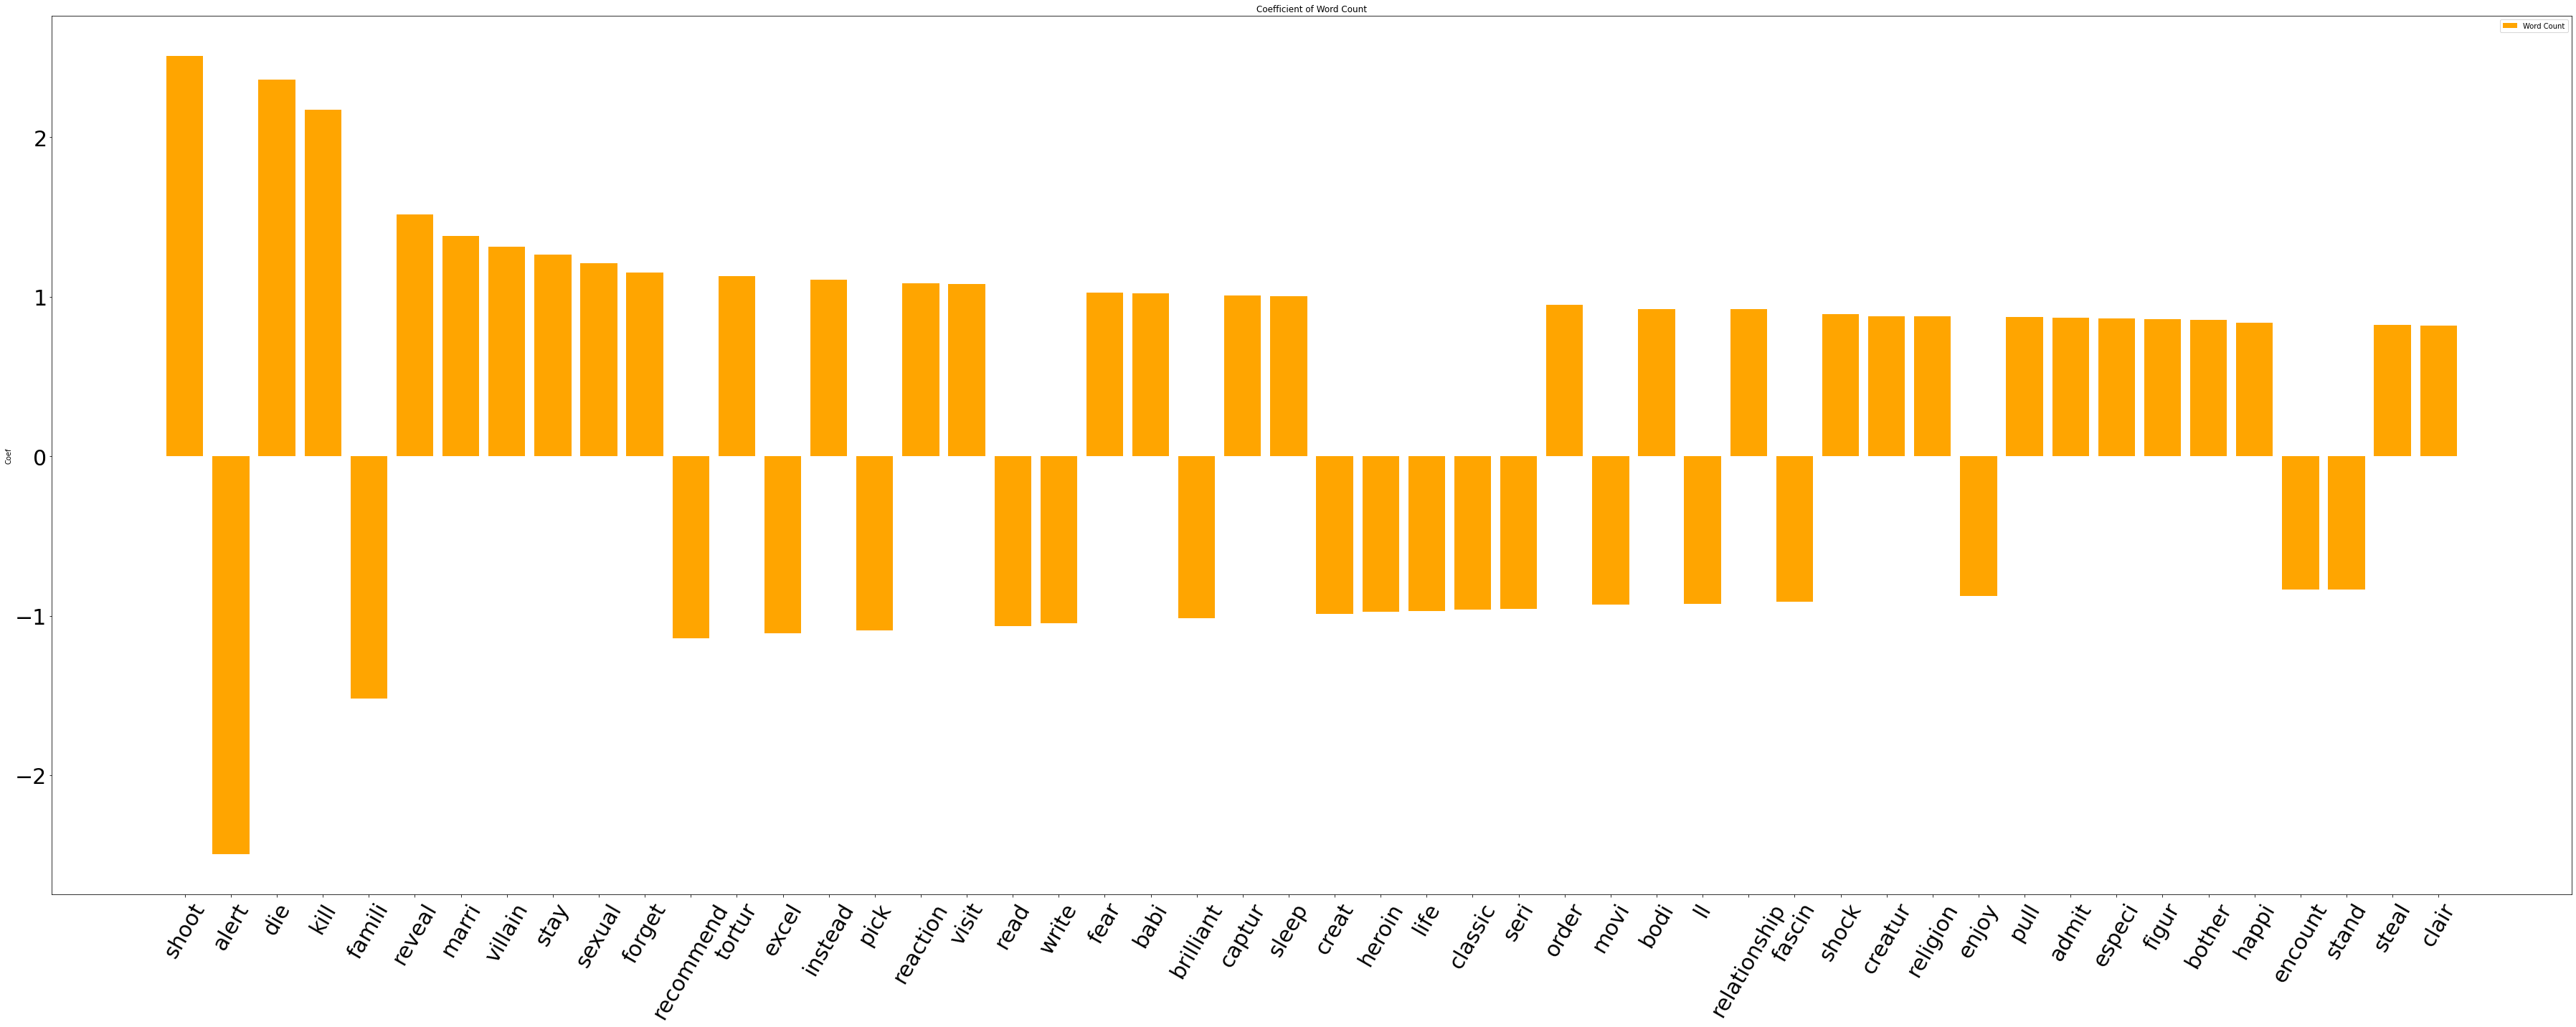

In [ ]:
%matplotlib inline

labels = sort_result.words
theta_word_count = sort_result.coef

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(50, 20))
rects1 = ax.bar(list(range(50)), theta_word_count, label='Word Count', color='orange')
ax.tick_params(axis='both', which='major', labelsize=30)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Coef')
ax.set_title('Coefficient of Word Count')
ax.set_xticks(x)
plt.setp(ax.get_xticklabels(), rotation=60)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# Step 4: LSTM


In this section, we evaluate the performance of deep neural network for this task and see if they can have a better performance than the weigthed SVM.

As for the SVM, we need to tokenize our text and encode it into something that the LSTM could understand. We make use of the ```Tokenizer``` from tensorflow that basically maps each word to a unique integer.

In [ ]:
# LSTM
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

X = sub_df.review_process
Y = sub_df.has_spoiler
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

max_words = 6000
max_len = 500
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [ ]:
features2 = pd.DataFrame(sequences_matrix)

Once we have our encoded text, we split it into a training and a test set :

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(features2, Y, test_size=0.1, random_state=21)
review_train, review_test = train_test_split(sub_df['review'], test_size=0.1, random_state=21)

Below we define a basic LSTM network and have a look at its performance and our data set.

In [ ]:
def my_LSTM():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,100,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
model = my_LSTM()
model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy',tf.keras.metrics.AUC(name="AUC")])
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 500)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 500, 100)          600000    
                                                                 
 lstm_6 (LSTM)               (None, 64)                42240     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_4 (Activation)   (None, 256)               0         
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [ ]:
start = time.time()
history = model.fit(X_train2,y_train2,batch_size=128,epochs=10,
          validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss',patience=2)])
end = time.time()
print('Training time of LSTM:', round(end-start,3), 'seconds')

Epoch 1/10
127/127 [==============================] - 16s 104ms/step - loss: 0.2193 - accuracy: 0.9541 - AUC: 0.5593 - val_loss: 0.1830 - val_accuracy: 0.9467 - val_AUC: 0.8027
Epoch 2/10
127/127 [==============================] - 11s 85ms/step - loss: 0.1168 - accuracy: 0.9617 - AUC: 0.8966 - val_loss: 0.1484 - val_accuracy: 0.9539 - val_AUC: 0.8709
Epoch 3/10
127/127 [==============================] - 11s 84ms/step - loss: 0.0777 - accuracy: 0.9744 - AUC: 0.9538 - val_loss: 0.1468 - val_accuracy: 0.9606 - val_AUC: 0.8535
Epoch 4/10
127/127 [==============================] - 11s 84ms/step - loss: 0.0674 - accuracy: 0.9762 - AUC: 0.9666 - val_loss: 0.1872 - val_accuracy: 0.9561 - val_AUC: 0.8204
Epoch 5/10
127/127 [==============================] - 11s 83ms/step - loss: 0.0426 - accuracy: 0.9861 - AUC: 0.9830 - val_loss: 0.1900 - val_accuracy: 0.9500 - val_AUC: 0.8219
Training time of LSTM: 59.153 seconds


In [ ]:
scores = model.predict(X_test2, verbose=0)
yhat_class2 = [1 if score>0.5 else 0 for score in scores]
fpr3, tpr3, _ = roc_curve(y_test2,  scores)

print("Testing accuracy: " + str(model.evaluate(X_test2,y_test2)[1]))
print("Precision on test data: " + str(precision_score(y_test2, yhat_class2)))
print("Recall on test data: " + str(recall_score(y_test2, yhat_class2)))
print("f1 score on test data: " + str(f1_score(y_test2, yhat_class2)))
print("AUC on test data: " + str(roc_auc_score(y_test2, scores)))

63/63 [==============================] - 2s 36ms/step - loss: 0.1863 - accuracy: 0.9520 - AUC: 0.8140
Testing accuracy: 0.9520000219345093
Precision on test data: 0.5294117647058824
Recall on test data: 0.2727272727272727
f1 score on test data: 0.36
AUC on test data: 0.8308067524269523


We can see that even though we don't tackle the imbalance problem, we manadge to reach a good level of AUC.

But again, we know that our data is imbalance and that's an issue to tackle. To do so, we make use of oversampling. We augment our data to make sure that we end up with a balanced data set.

In [ ]:
# Balanced LSTM
# Solution: Oversampling
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_o2, y_train_o2 = oversample.fit_resample(X_train2, y_train2)

In [ ]:
model_bal = my_LSTM()
model_bal.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

In [ ]:
start = time.time()
model_bal.fit(X_train_o2,y_train_o2,batch_size=128,epochs=10,
          validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])
end = time.time()
print('Training time of Balanced LSTM:', round(end-start,3), 'seconds')

Epoch 1/10
242/242 [==============================] - 24s 85ms/step - loss: 0.2485 - accuracy: 0.8873 - val_loss: 0.0611 - val_accuracy: 0.9893
Epoch 2/10
242/242 [==============================] - 20s 81ms/step - loss: 0.0591 - accuracy: 0.9826 - val_loss: 0.0296 - val_accuracy: 0.9980
Training time of Balanced LSTM: 44.248 seconds


In [ ]:
scores = model_bal.predict(X_test2, verbose=0)
yhat_class_o2 = np.array([1 if score>0.5 else 0 for score in scores])
y_test2 = y_test2.flatten()
fpr4, tpr4, _ = roc_curve(y_test2,  scores)

print("Testing accuracy: " + str(model_bal.evaluate(X_test2,y_test2)[1]))
print("Precision on test data: " + str(precision_score(y_test2, yhat_class_o2)))
print("Recall on test data: " + str(recall_score(y_test2, yhat_class_o2)))
print("f1 score on test data: " + str(f1_score(y_test2, yhat_class_o2)))
print("AUC on test data: " + str(roc_auc_score(y_test2, scores)))

63/63 [==============================] - 2s 36ms/step - loss: 0.2780 - accuracy: 0.9480
Testing accuracy: 0.9480000138282776
Precision on test data: 0.4731182795698925
Recall on test data: 0.4444444444444444
f1 score on test data: 0.45833333333333337
AUC on test data: 0.8581820307227986


### Attention-LSTM with weighted loss:



To boost even more our model, we can use of a Bidirectionnal LSTM and add an attention layer afterward to select the most important words. Also instead of oversampling, we balanced the loss by adding weights :
$$l = w_p\textrm{log}(\hat{p})+w_n\textrm{log}(1-\hat{p})$$

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip
import os
import pathlib

path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/gdrive/MyDrive/ads_proj5/ads-spring-2022-prj5-group-4/lib/glove.6B.100d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

# LSTM
from keras import backend as K
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import normalize
%matplotlib inline
max_words = 6000
max_len = 500


X = sub_df.review_process
Y = sub_df.has_spoiler
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=max_words, output_sequence_length=max_len)
text_ds = tf.data.Dataset.from_tensor_slices(X).batch(128)
vectorizer.adapt(text_ds)
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
num_tokens = len(voc)
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
features = pd.DataFrame(sequences_matrix)
X_train, X_test, y_train, y_test = train_test_split(features, Y, test_size=0.1, random_state=21, stratify=Y)

Converted 4305 words (1695 misses)


In [ ]:
from tensorflow.keras.layers import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout
from keras import backend as K
from keras.models import Model

def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatibl|e with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

def SpoilerLSTM():
    inputs_text = layers.Input(name='inputs',shape=[max_len])
    embbed_input_text = layers.Embedding(max_words,embedding_dim,input_length=max_len,trainable=True,embeddings_initializer=keras.initializers.Constant(embedding_matrix))(inputs_text) # Add to initialize with GloVe embeddings_initializer=keras.initializers.Constant(embedding_matrix)
    word_lstm =  layers.Bidirectional(layers.LSTM(64,return_sequences=True))(embbed_input_text)
    word_dense = TimeDistributed(Dense(128))(word_lstm)
    attention_layer = AttentionWithContext()(word_dense)
    layer = layers.Dropout(0.5)(attention_layer)
    layer = layers.Dense(1,activation="sigmoid")(layer)
    model = Model(inputs=inputs_text,outputs=layer)
    return model

In [ ]:
model = SpoilerLSTM()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        0.003,
        decay_steps=100000,
        decay_rate=0.9,
        staircase=True
    )
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=lr_schedule),metrics=['accuracy',tf.keras.metrics.AUC(name="AUC")])

from sklearn.utils import class_weight

weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=np.reshape(y_train,(-1)))
weights = dict(enumerate(weights))

checkpoint_filepath = "./doc/tmp/checkpoint_LSTM"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="AUC",
        save_best_only=True,
        save_weights_only=True,
    )

early_stoping_callback = tf.keras.callbacks.EarlyStopping(monitor='AUC', patience=2)

In [ ]:
start = time.time()
model.fit(X_train,y_train,batch_size=64,epochs=15, validation_split=0.1,callbacks=early_stoping_callback, class_weight=weights)
end = time.time()
print('Training time of Modified LSTM:', round(end-start,3), 'seconds')

Epoch 1/15
254/254 [==============================] - 59s 167ms/step - loss: 0.6418 - accuracy: 0.5896 - AUC: 0.6876 - val_loss: 0.3596 - val_accuracy: 0.8728 - val_AUC: 0.9105
Epoch 2/15
254/254 [==============================] - 40s 156ms/step - loss: 0.3709 - accuracy: 0.8598 - AUC: 0.9128 - val_loss: 0.2645 - val_accuracy: 0.9150 - val_AUC: 0.9362
Epoch 3/15
254/254 [==============================] - 39s 156ms/step - loss: 0.2075 - accuracy: 0.9289 - AUC: 0.9704 - val_loss: 0.1870 - val_accuracy: 0.9372 - val_AUC: 0.9230
Training time of Modified LSTM: 138.208 seconds


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score,roc_auc_score
# model = SpoilerLSTM()
# model.load_weights(root+"/tmp/checkpoint_LSTM")
scores = model.predict(X_test, verbose=0)
yhat_class = [1 if score>0.5 else 0 for score in scores]
fpr5, tpr5, _ = roc_curve(y_test,  scores)

print("Testing accuracy: " + str(model.evaluate(X_test,y_test)[1]))
print("Precision on test data: " + str(precision_score(y_test, yhat_class)))
print("Recall on test data: " + str(recall_score(y_test, yhat_class)))
print("f1 score on test data: " + str(f1_score(y_test, yhat_class)))
print("AUC on test data: " + str(roc_auc_score(y_test, scores)))

63/63 [==============================] - 4s 61ms/step - loss: 0.2012 - accuracy: 0.9380 - AUC: 0.9104
Testing accuracy: 0.9380000233650208
Precision on test data: 0.38562091503267976
Recall on test data: 0.6629213483146067
f1 score on test data: 0.48760330578512395
AUC on test data: 0.9116704590219838


# Step 5: Comparison

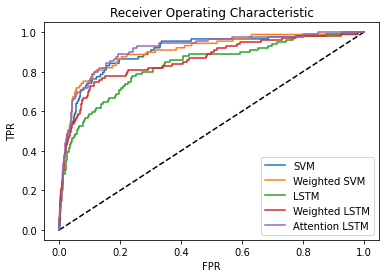

In [ ]:
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "SVM")
plt.plot(fpr2, tpr2, label= "Weighted SVM")
plt.plot(fpr3, tpr3, label= "LSTM")
plt.plot(fpr4, tpr4, label= "Weighted LSTM")
plt.plot(fpr5, tpr5, label= "Attention LSTM")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()